In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/split_data_balanced"

In [3]:
import os

files = os.listdir(path)
print(files)


['.DS_Store', 'test', 'train', 'models']


In [4]:
pip install torch torchvision

In [5]:
pip install fastai

In [6]:
import fastai
from fastai.vision.all import *
from fastai.callback.all import *

In [7]:
# Define the data loaders
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2, test='test',
                                   item_tfms=Resize(224), batch_size=32)

In [ ]:
#dls.train.show_batch()

In [ ]:
#dls.valid.show_batch()

In [8]:
#Training the model using transfer learning through pretrained resnet34 model
learn = cnn_learner(dls, resnet34, metrics=error_rate, opt_func=Adam,lr=0.0001, pretrained=True)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

In [9]:
learn.freeze()

In [ ]:
learn.lr_find()


KeyboardInterrupt: ignored

In [10]:
learn.fine_tune(epochs=20, base_lr=0.0001)

TypeError: ignored

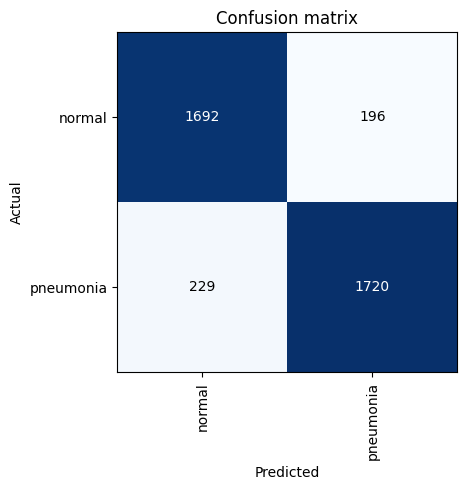

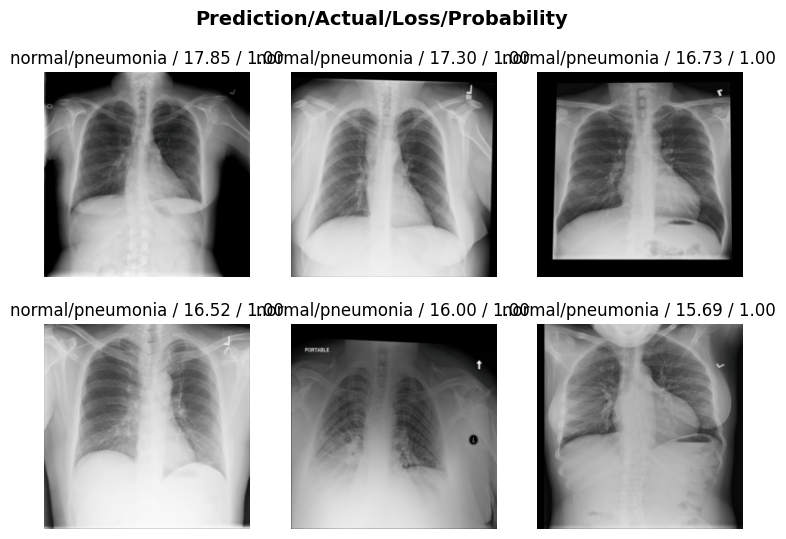

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

In [17]:
learn.recorder.final_record



(#2) [0.011485833674669266,0.004429678898304701]

In [13]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)
val_accuracy = accuracy(val_preds, val_targets)

In [14]:
val_accuracy

TensorBase(0.8892)

In [15]:
train_preds, train_targets = learn.get_preds(dl=dls.train)
train_accuracy = accuracy(train_preds, train_targets)

In [16]:
train_accuracy

TensorBase(0.9956)

In [18]:
#Test accuracy for normal scans
from fastai.vision.utils import get_image_files

# Define the path to the folder containing the images
folder_path = '/content/drive/MyDrive/split_data_balanced/test/normal'

# Get a list of image file paths from the folder
image_files = get_image_files(folder_path)

# Initialize dictionaries to keep count of predictions for each class
class_counts = {learn.dls.vocab[i]: 0 for i in range(len(learn.dls.vocab))}
total_images = len(image_files)

# Loop through the images and get predictions
for img_path in image_files:
    img = PILImage.create(img_path)
    pred, pred_idx, probs = learn.predict(img)
    class_counts[pred] += 1

# Display the prediction counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} ({count/total_images:.2%})")


normal: 1874 (97.66%)
pneumonia: 45 (2.34%)


In [19]:
#Test accuracy for pneumonia scans

from fastai.vision.utils import get_image_files

# Define the path to the folder containing the images
folder_path = '/content/drive/MyDrive/split_data_balanced/test/pneumonia'
# Get a list of image file paths from the folder
image_files = get_image_files(folder_path)

# Initialize dictionaries to keep count of predictions for each class
class_counts = {learn.dls.vocab[i]: 0 for i in range(len(learn.dls.vocab))}
total_images = len(image_files)

# Loop through the images and get predictions
for img_path in image_files:
    img = PILImage.create(img_path)
    pred, pred_idx, probs = learn.predict(img)
    class_counts[pred] += 1

# Display the prediction counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} ({count/total_images:.2%})")


normal: 56 (2.92%)
pneumonia: 1863 (97.08%)


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert predictions to class labels (0 or 1)
val_preds_class = val_preds.argmax(dim=1)

# Convert tensor targets to numpy arrays
val_targets_np = val_targets.numpy()
val_preds_class_np = val_preds_class.numpy()

# Calculate precision, recall, and F1 score
precision = precision_score(val_targets_np, val_preds_class_np)
recall = recall_score(val_targets_np, val_preds_class_np)
f1 = f1_score(val_targets_np, val_preds_class_np)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8977
Recall: 0.8825
F1 Score: 0.8900


In [20]:
learn.state_dict

<bound method Module.state_dict of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [22]:
import torch

# Assuming your model is named 'model'
torch.save(learn.state_dict(), 'learn1.pth')


In [23]:
from google.colab import files

files.download('learn1.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>